<a href="https://colab.research.google.com/github/ChrisFJardine/Masterclass/blob/main/CJardineAssignment3__Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import re
import time
import datetime
import os
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn


%matplotlib inline 
from datetime import datetime, timedelta

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/ExtractedNews.csv', header = None)

In [ ]:
docs = []
for x in range(news.shape[1]):
  for y in range(news.shape[0]):
    if isinstance(news[x][y], str):
      docs.append(news[x][y])
df = pd.DataFrame(docs)

In [ ]:
df = pd.DataFrame(docs)
df['date'] = df[0].apply(lambda x: datetime.strptime(re.search(r'\d{4}-\d{2}-\d{2}', str(x)).group(),'%Y-%m-%d').date())
df['text'] = df[0].str.replace('[^\w\s]', '')
df['text'] = df['text'].str.replace('\d+','')
df['text'] = df['text'].str.lstrip()
df['text'] = df['text'].str.lower()                                           #all to lower case
df = df.drop(df.columns[[0]], 1)
df.sort_values(by='date', inplace=True)


In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df['sentiment'] = df.apply(lambda x: sid.polarity_scores(x.text), axis=1)
df['compound']  = df['sentiment'].apply(lambda score_dict: score_dict['compound'])


In [ ]:
df_grouped = df.groupby('date').mean()

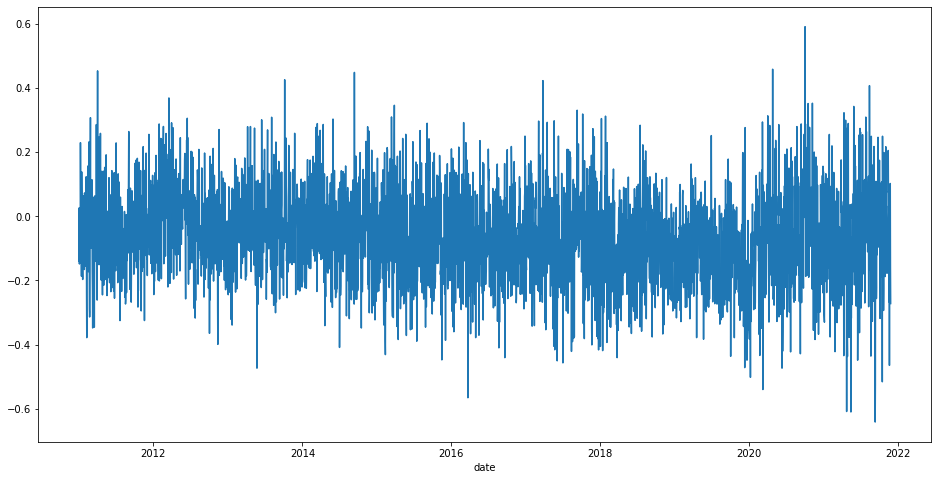

In [ ]:
df_grouped['compound'].plot(figsize = (16,8))

In [ ]:
df_grouped['sentiment'] = df_grouped['compound'].rolling(window=30).mean() 

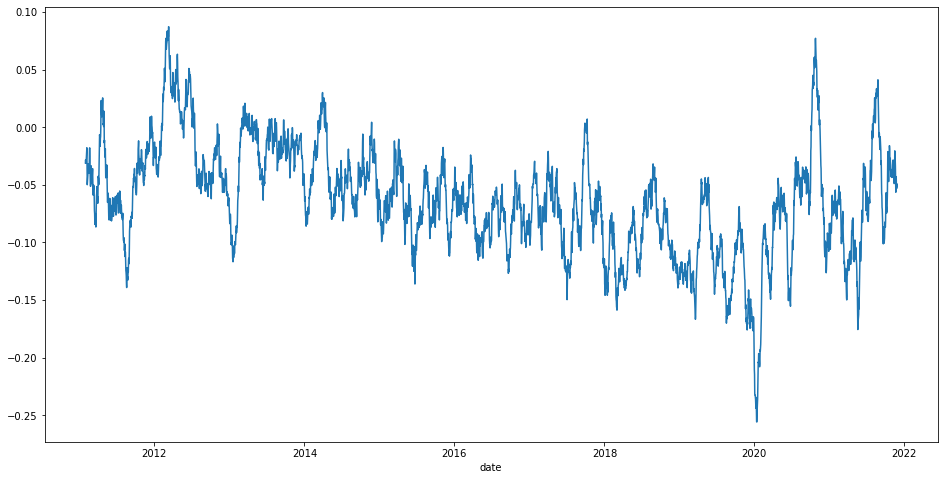

In [ ]:
df_grouped['sentiment'].plot(figsize = (16,8))

In [ ]:
stop = stopwords.words('english')
df['words'] = df['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


In [ ]:
df2012 = df[( df['date'] > pd.Timestamp(2012,1,1))  &  (df['date'] < pd.Timestamp(2013,1,1)) ] 
listwords2012 = ' '.join([x for x in df2012.words]).split()

df2019 = df[( df['date'] > pd.Timestamp(2019,1,1))  &  (df['date'] < pd.Timestamp(2020,1,1)) ] 
listwords2019 = ' '.join([x for x in df2019.words]).split()


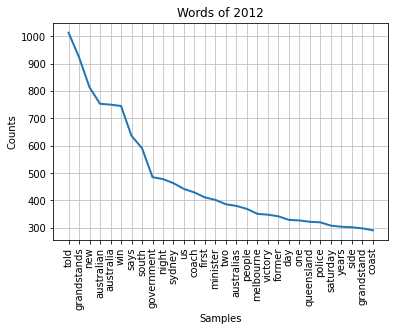

In [ ]:
fdist = FreqDist(listwords2012)
fdist.plot(30, cumulative = False, title = 'Words of 2012' )

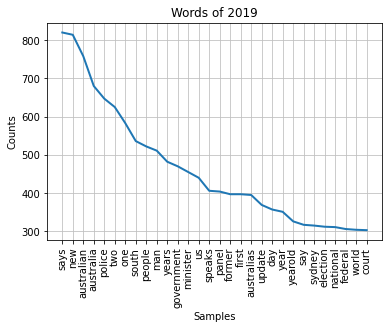

In [ ]:
fdist = FreqDist(listwords2019)
fdist.plot(30, cumulative = False, title = 'Words of 2019')

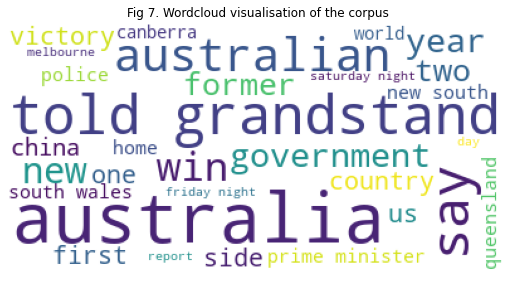

In [ ]:

text = " ".join(desc for desc in listwords2012)
wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Fig 7. Wordcloud visualisation of the corpus')
plt.axis("off")
plt.show()

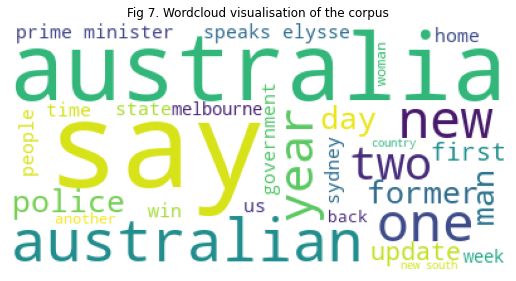

In [ ]:
text = " ".join(desc for desc in listwords2019)
wordcloud = WordCloud(max_words = 30, background_color="white").generate(text)
plt.figure(figsize = [9,9])
plt.imshow(wordcloud, interpolation='antialiased')
plt.title('Fig 7. Wordcloud visualisation of the corpus')
plt.axis("off")
plt.show()

In [ ]:
cricket = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Assignment 3/AusCricketResults.csv')
cricket = cricket.dropna()
cricket[['days','year']] = cricket['Match Date'].str.split(',', expand = True)
cricket[['test_start', 'test_end']] = cricket['days'].str.split('-', expand = True)
cricket['test_date'] = cricket['test_start']  + cricket['year']
cricket['test_date'] = pd.to_datetime(cricket['test_date'])
cricket.drop(['days', 'year', 'test_start','test_end'], axis=1, inplace=True)
cricket['score'] = 0
cricket.loc[cricket['Winner'] == 'Australia', 'score' ] = 1  
cricket['momentum'] = cricket['score'].rolling(window=10).mean()


In [ ]:
crick_trend =  cricket[['test_date','momentum']].fillna(0)
crick_trend['test_date'] = pd.to_datetime(crick_trend['test_date'])
#crick_trend.plot(figsize = (16,8))
crick_trend = crick_trend.set_index('test_date')
#df_grouped.join(crick_trend)


In [ ]:
data = df_grouped.join(crick_trend)
data = data.drop(['compound'], axis = 1)


In [ ]:
data.iloc[0]['momentum'] = 0.4
data['momentum'] = data['momentum'].fillna(method='ffill')
data = data.fillna(0)


In [ ]:
cols_to_norm = ['sentiment','momentum']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

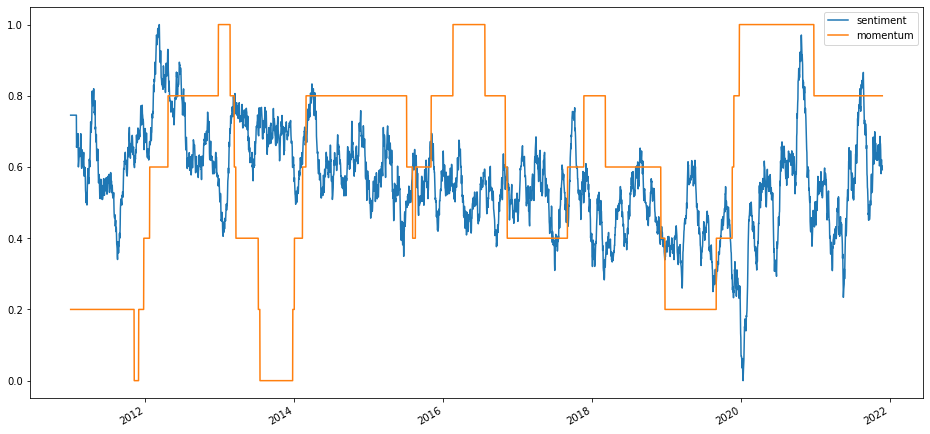

In [ ]:
data.plot(figsize = (16,8))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


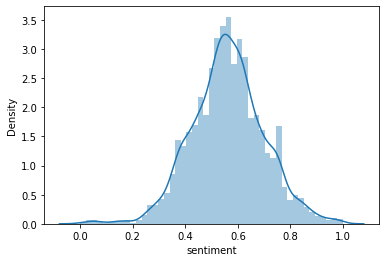

In [ ]:
#Try a regression model
seaborn.distplot(data['sentiment'])

In [ ]:
#Try a regression model
X = data['momentum'].values.reshape(-1,1)
y = data['sentiment'].values.reshape(-1,1)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [ ]:
regressor = LinearRegression()  
regressor.fit(train_X, train_y)
y_pred = regressor.predict(test_X)
results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': y_pred.flatten()})
results

In [ ]:
data['momentum'].corr(data['sentiment'])
#Pearson correlation close to 0. Not correlated.

-0.075974829459687

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))


Mean Absolute Error: 0.10853064477982005
Mean Squared Error: 0.01996852560040602
Root Mean Squared Error: 0.14131003361547267
